In [69]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os
etopo = xr.open_dataset('/home1/datawork/kbalem/ETOPO1_Bed_g_gmt4.nc')
gebco = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2019.nc')

In [2]:
import copernicus_marine_client as copernicus_marine

In [70]:
glomu = xr.open_dataset('Glorys_mean/mercatorglorys12v1_gl12_mean_uo-ave2000-2020-ave-all-deps.nc')
glomv = xr.open_dataset('Glorys_mean/mercatorglorys12v1_gl12_mean_vo-ave2000-2020-ave-all-deps.nc')
glomus = xr.open_dataset('Glorys_mean/mercatorglorys12v1_gl12_mean_uo-ave2000-2020-surf.nc')
glomvs = xr.open_dataset('Glorys_mean/mercatorglorys12v1_gl12_mean_vo-ave2000-2020-surf.nc')

### Let's see what's the mean surface drift duration for deep arvor
with that we will apply a surface correction to the grounding position, in addition to the water column averaged correction

In [21]:
ix = pd.read_csv('/home/ref-argo/gdac/ar_index_global_prof.txt', 
                 sep=',', index_col=None, header=0, skiprows=8,
                 names=['file','date','latitude','longitude','ocean','profiler_type','institution','update'], 
                 dtype={'file': np.unicode_, 'latitude': np.float32, 'longitude': np.float32, 'ocean': str, 'profiler_type': str, 'institution': str}
                )
ixs = ix[(ix['profiler_type']=='838')]

ixs = ixs.reset_index().drop(columns='index')
# parse the date after the subset, much more fast than inside the pd.read_csv()
ixs['date']= pd.to_datetime(ixs['date'],format='%Y%m%d%H%M%S')
# period of interest [datemin, datemax]
poi = np.array(['2000-01-01','2023-11-30'],dtype='datetime64')
ixs = ixs[(ixs['date']>=poi[0])&(ixs['date']<=poi[1])].reset_index()

# dac generation
dacs = {'AO':'aoml','BO':'bodc','IF':'coriolis','HZ':'csio','CS':'csiro','IN':'incois','JA':'jma','KM':'kma','KO':'kordi','ME':'meds','NM':'nmdis'}
ixs['wmo']=[int(f.split('/')[1]) for f in ixs['file']]
ixs['dac']=[dacs[f] for f in ixs['institution']]
ixs = ixs.groupby('wmo').last().reset_index()
ixs.tail()

,wmo,index,file,date,latitude,longitude,ocean,profiler_type,institution,update,dac
120,6903872,9187,coriolis/6903872/profiles/R6903872_090.nc,2023-11-28 11:18:00,61.070999,-39.436001,A,838,IF,20231128122857,coriolis
121,6903873,9286,coriolis/6903873/profiles/R6903873_089.nc,2023-11-20 07:02:00,49.098999,-42.205002,A,838,IF,20231120083126,coriolis
122,6990538,9313,coriolis/6990538/profiles/R6990538_016.nc,2023-11-22 00:06:00,53.640999,-26.841999,A,838,IF,20231122012547,coriolis
123,7901036,9339,coriolis/7901036/profiles/R7901036_015.nc,2023-11-22 16:09:00,59.508999,-48.191002,A,838,IF,20231122172659,coriolis
124,7901037,9365,coriolis/7901037/profiles/R7901037_015.nc,2023-11-21 18:15:00,58.676998,-41.412998,A,838,IF,20231121192657,coriolis


In [26]:
def surface_duration(x):
    return x['JULD'][-1]-x['JULD'][0]

sdu = np.zeros(len(ixs))

for i in range(len(ixs)):
    urlt="/home/ref-argo/gdac/dac/"+ixs['dac'][i]+"/"+str(ixs['wmo'][i])+"/"+str(ixs['wmo'][i])+"_Rtraj.nc"       
    dt = xr.open_dataset(urlt)
    sd = dt[['CYCLE_NUMBER','JULD','LATITUDE','LONGITUDE']].where(dt['MEASUREMENT_CODE']==703.,drop=True).groupby('CYCLE_NUMBER').apply(surface_duration).values.astype(int)
    sdu[i] = np.mean(sd/(3600*1e9))

Text(0, 0.5, 'Surface drift duration (hours)')

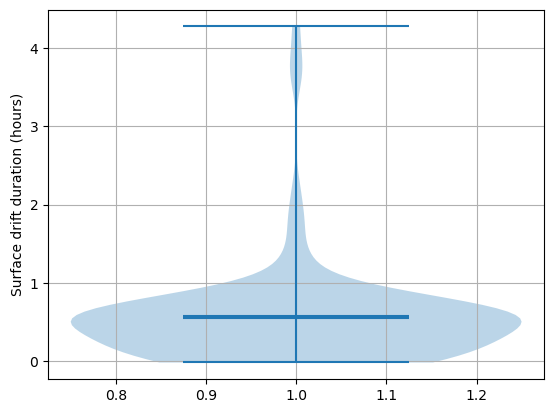

In [46]:
_ = plt.violinplot(sdu[sdu<10],showmeans=True,showmedians=True)
plt.ylabel('Surface drift duration (hours)')

In [52]:
np.median(sdu)*3600

2112.46000014592

----

In [91]:
df1 = xr.open_dataset('working_ds_2000-2020_positions.nc')
df1

<xarray.Dataset>
Dimensions:          (N_GRD: 3908)
Dimensions without coordinates: N_GRD
Data variables: (12/17)
    LATITUDE         (N_GRD) float64 ...
    LONGITUDE        (N_GRD) float64 ...
    PROFILER_TYPE    (N_GRD) float64 ...
    CYCLE_NUMBER     (N_GRD) float64 ...
    WMO              (N_GRD) float64 ...
    GROUNDING_DATE   (N_GRD) datetime64[ns] ...
    ...               ...
    LATITUDE_C0      (N_GRD) float64 ...
    LATITUDE_C1      (N_GRD) float64 ...
    LONGITUDE_C0     (N_GRD) float64 ...
    LONGITUDE_C1     (N_GRD) float64 ...
    LATITUDE_C2      (N_GRD) float64 ...
    LONGITUDE_C2     (N_GRD) float64 ...
Attributes:
    title:              Grounding data from Deep Arvor floats
    author:             Kevin Balem
    author_affilation:  IFREMER-LOPS
    author_contact:     kevin.balem@ifremer.fr
    date:               2024-01-15T08:35:25
    Processing 1:       Only grounding occuring during descent to profile are...
    Processing 2:       Corrected positions are calculated from the first GPS...

In [72]:
def correct_from_glorysclim(du):
    #times
    ascent_duration = int((du.PROFILE_DATE - du.GROUNDING_DATE).values)/(1e9) #seconds
    drift_duration = 2000 #seconds
    #displacements
    iu = -1*ascent_duration*glomu['uo'].interp(latitude=du.LATITUDE.values,longitude=du.LONGITUDE.values).values
    iv = -1*ascent_duration*glomv['vo'].interp(latitude=du.LATITUDE.values,longitude=du.LONGITUDE.values).values
    ius = -1*drift_duration*glomus['uo'].interp(latitude=du.LATITUDE.values,longitude=du.LONGITUDE.values).values
    ivs = -1*drift_duration*glomvs['vo'].interp(latitude=du.LATITUDE.values,longitude=du.LONGITUDE.values).values    
    #surface drift correction
    azim1 = np.degrees(np.arctan2(ius,ivs))
    dist1 = np.sqrt(ius**2 + ivs**2)
    origin1 = Geodesic().direct([du.LONGITUDE.values,du.LATITUDE.values],azim1,dist1) 
    #water column correction
    azim0 = np.degrees(np.arctan2(iu,iv))
    dist0 = np.sqrt(iu**2 + iv**2)
    origin0 = Geodesic().direct([origin1[0][0], origin1[0][1]],azim0,dist0)
    
    return origin0[0][0], origin0[0][1], origin1[0][0], origin1[0][1]

In [4]:
def get_coords_corrected_glo(du):    
    # Set parameters
    ds_id = "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m"
    
    print("Downloading velocities on CMEMS : ",ds_id)
    # Load xarray dataset
    vel_glo = copernicus_marine.open_dataset(
        dataset_id = ds_id,
        minimum_longitude = du.LONGITUDE.values-.2,
        maximum_longitude = du.LONGITUDE.values+.2,
        minimum_latitude = du.LATITUDE.values-.2,
        maximum_latitude = du.LATITUDE.values+.2,
        start_datetime = '2000-01-01',
        end_datetime = '2020-12-31',
        variables = ["uo","vo"]
    )
    vel_glo = vel_glo.mean('time')
    print("Calculating corrected grounding position ...")
    ascent_duration = int((du.PROFILE_DATE - du.GROUNDING_DATE).values)/(1e9)
    uom = -1*ascent_duration*vel_glo.where(vel_glo['depth']<du.GROUNDING_DEPTH.values,drop=True)['uo'].interp(latitude=du['LATITUDE'].values,
                                                                                                              longitude=du['LONGITUDE'].values).mean('depth').values
    vom = -1*ascent_duration*vel_glo.where(vel_glo['depth']<du.GROUNDING_DEPTH.values,drop=True)['vo'].interp(latitude=du['LATITUDE'].values,
                                                                                                              longitude=du['LONGITUDE'].values).mean('depth').values
    azim = np.degrees(np.arctan2(uom,vom))
    dist = np.sqrt(uom**2 + vom**2)
    origin = Geodesic().direct([du.LONGITUDE.values,du.LATITUDE.values],azim,dist)    
    return origin[0][0], origin[0][1], vel_glo

In [16]:
def get_coords_corrected_cli(du):    
    # Set parameters
    ds_id = "cmems_mod_glo_phy_my_0.083deg-climatology_P1M-m"
    print("Downloading velocities on CMEMS : ",ds_id)
    # Load xarray dataset
    vel_glo = copernicus_marine.open_dataset(
        dataset_id = ds_id,
        minimum_longitude = du.LONGITUDE.values-.2,
        maximum_longitude = du.LONGITUDE.values+.2,
        minimum_latitude = du.LATITUDE.values-.2,
        maximum_latitude = du.LATITUDE.values+.2,
        start_datetime = '1993-01-01',
        end_datetime = '1993-12-31',
        variables = ["uo","vo"]
    )
    vel_glo = vel_glo.mean('time')
    print("Calculating corrected grounding position ...")
    ascent_duration = int((du.PROFILE_DATE - du.GROUNDING_DATE).values)/(1e9)
    uom = -1*ascent_duration*vel_glo.where(vel_glo['depth']<du.GROUNDING_DEPTH.values,drop=True)['uo'].interp(latitude=du['LATITUDE'].values,
                                                                                                              longitude=du['LONGITUDE'].values).mean('depth').values
    vom = -1*ascent_duration*vel_glo.where(vel_glo['depth']<du.GROUNDING_DEPTH.values,drop=True)['vo'].interp(latitude=du['LATITUDE'].values,
                                                                                                              longitude=du['LONGITUDE'].values).mean('depth').values
    azim = np.degrees(np.arctan2(uom,vom))
    dist = np.sqrt(uom**2 + vom**2)
    origin = Geodesic().direct([du.LONGITUDE.values,du.LATITUDE.values],azim,dist)    
    return origin[0][0], origin[0][1], vel_glo

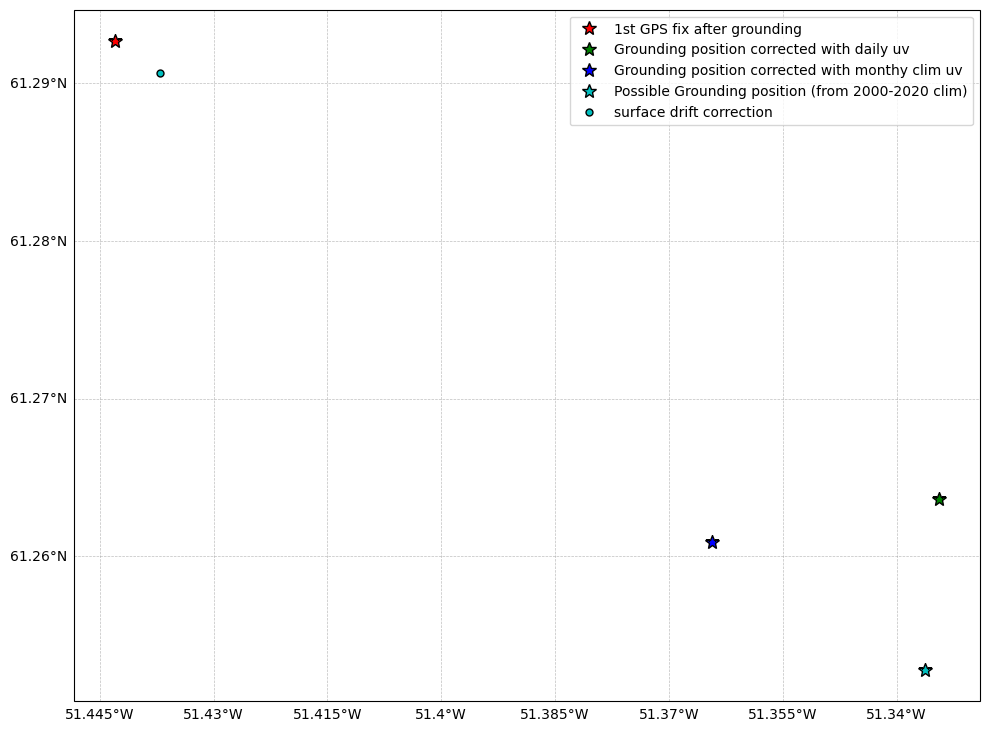

In [118]:
i = 1700
du = df1.isel(N_GRD=i)
lon_ci0,lat_ci0,lon_ci0t,lat_ci0t = correct_from_glorysclim(df1.isel(N_GRD=i))

fig=plt.figure(figsize=(10,10),tight_layout=True)
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

ax.plot(du['LONGITUDE'],du['LATITUDE'],'*r', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='1st GPS fix after grounding')
ax.plot(du['LONGITUDE_C0'],du['LATITUDE_C0'],'*g', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Grounding position corrected with daily uv')
ax.plot(du['LONGITUDE_C1'],du['LATITUDE_C1'],'*b', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Grounding position corrected with monthy clim uv')
#ax.plot(du['LONGITUDE_C2'],du['LATITUDE_C2'],'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Grounding position corrected with 2000-2020 clim uv')

ax.plot(lon_ci0,lat_ci0,'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Possible Grounding position (from 2000-2020 clim)')
ax.plot(lon_ci0t,lat_ci0t,'.c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='surface drift correction')

plt.legend()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

Plotting


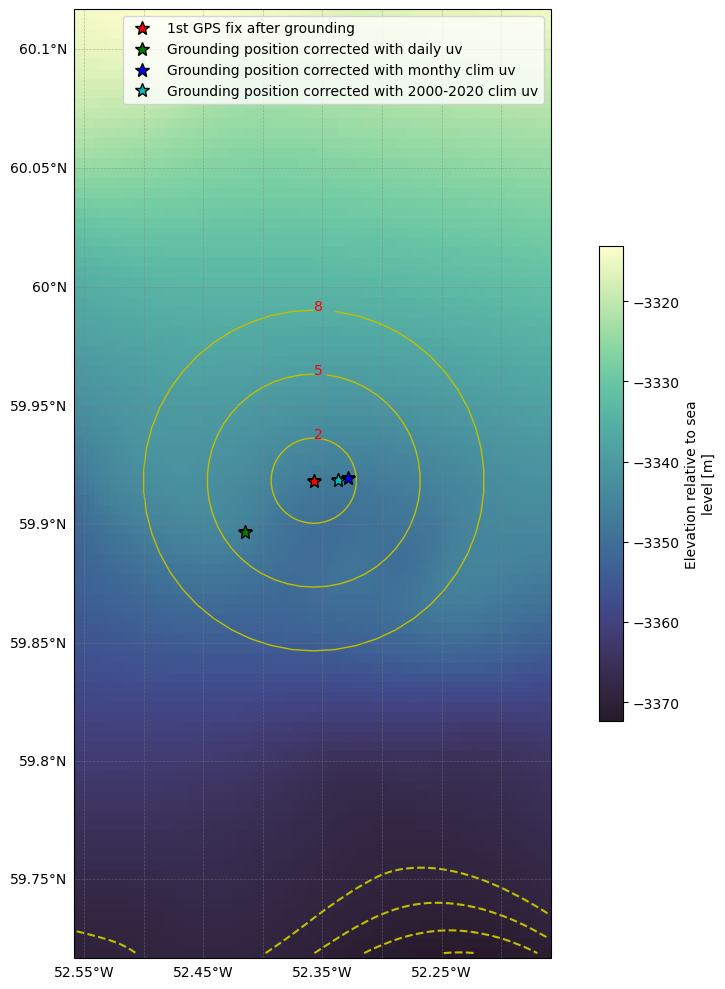

In [108]:
i = 1300
du = df1.isel(N_GRD=i)

#lon_ci0,lat_ci0,vel = get_coords_corrected_glo(df1.isel(N_GRD=i))
#vel = vel.where(vel['depth']<du.GROUNDING_DEPTH.values,drop=True).mean('depth')
lon_ci0,lat_ci0,lon_ci0t,lat_ci0t = correct_from_glorysclim(df1.isel(N_GRD=i))

print("Plotting")
#bathy = etopo
bathy = gebco
#bdim={'x':'x','y':'y','z':'z'}
bdim={'x':'lon','y':'lat','z':'elevation'}
rsize=.2

fig=plt.figure(figsize=(10,10),tight_layout=True)
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)

bathy.where((bathy[bdim['x']]>du['LONGITUDE'].values-rsize)&(bathy[bdim['x']]<du['LONGITUDE'].values+rsize)&(bathy[bdim['y']]>du['LATITUDE'].values-rsize)&(bathy[bdim['y']]<du['LATITUDE'].values+rsize),
            drop=True)[bdim['z']].plot(cmap=cmocean.cm.deep_r, cbar_kwargs={'shrink': 0.5},ax=ax, transform=ccrs.PlateCarree())
bathy.where((bathy[bdim['x']]>du['LONGITUDE'].values-rsize)&(bathy[bdim['x']]<du['LONGITUDE'].values+rsize)&(bathy[bdim['y']]>du['LATITUDE'].values-rsize)&(bathy[bdim['y']]<du['LATITUDE'].values+rsize),
            drop=True)[bdim['z']].plot.contour(x=bdim['x'],y=bdim['y'],levels=np.arange(-du['GROUNDING_DEPTH']-5,-du['GROUNDING_DEPTH']+5),colors='y',ax=ax, transform=ccrs.PlateCarree())

ax.plot(du['LONGITUDE'],du['LATITUDE'],'*r', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='1st GPS fix after grounding')
ax.plot(du['LONGITUDE_C0'],du['LATITUDE_C0'],'*g', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Grounding position corrected with daily uv')
ax.plot(du['LONGITUDE_C1'],du['LATITUDE_C1'],'*b', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Grounding position corrected with monthy clim uv')
ax.plot(du['LONGITUDE_C2'],du['LATITUDE_C2'],'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Grounding position corrected with 2000-2020 clim uv')

#ax.plot(lon_ci0,lat_ci0,'*c', markersize=10, markeredgecolor='k', alpha=1, transform=ccrs.PlateCarree(),zorder=10,label='Possible Grounding position (from 2000-2020 clim)')
#ax.plot(lon_ci0t,lat_ci0t,'.y', markersize=5, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree(),zorder=10)

#vel.plot.quiver(x='longitude',y='latitude',u='uo',v='vo',ax=ax,transform=ccrs.PlateCarree())

plt.legend()

rads = [2,5,8]
for r in rads:
    PTS=np.array(Geodesic().circle(lon=du['LONGITUDE'].values,lat=du['LATITUDE'].values,radius=r*1000,n_samples=50))
    ax.plot(PTS[:,0],PTS[:,1],'y-',linewidth=1, transform=ccrs.PlateCarree())
    ax.text(PTS[0,0],PTS[0,1],str(r),color='r',transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER